1、修改标注点集顺序为，依次连接n个点形成n个向量（首尾相连），其右侧法向量始终指向多边形内部
2、依次产生n个向量的左侧法向量，生成距离为d的新点
3、裁剪掉落在图像边界之外的点

1、以某点集的第一个点指向第二个点为初始向量，求其法向量
2、保留初始向量与法向量叉乘为负的那个法向量（左侧法向量）
3、判断沿2中法向量移动单位距离的点是否位于外部
4、是 则退出，否 则逆序初始点集

-------------------
1、依次求出每个向量的左侧法向量的单位向量ti

2、依次沿ti修改向量起点，坐标增量为d^0.5(xti,yti)

-------------------
函数说明
all_normal_vector:
输入	labelme风格的点集：n个坐标点
输出	向量集合：n个向量，法向量集合：2n个法向量

left_normal_vector:
输入	向量集合：n个向量，法向量集合，2n个法向量
输出	左侧法向量：n个向量

unit_vector:
..

cv2.pointPolygonTest counuter,point,0

https://kb.kutu66.com/python/post_2222359
https://blog.csdn.net/weixin_38564268/article/details/91445719
https://www.programcreek.com/python/example/89439/cv2.pointPolygonTest
    
https://blog.csdn.net/weixin_42886817/article/details/102668067
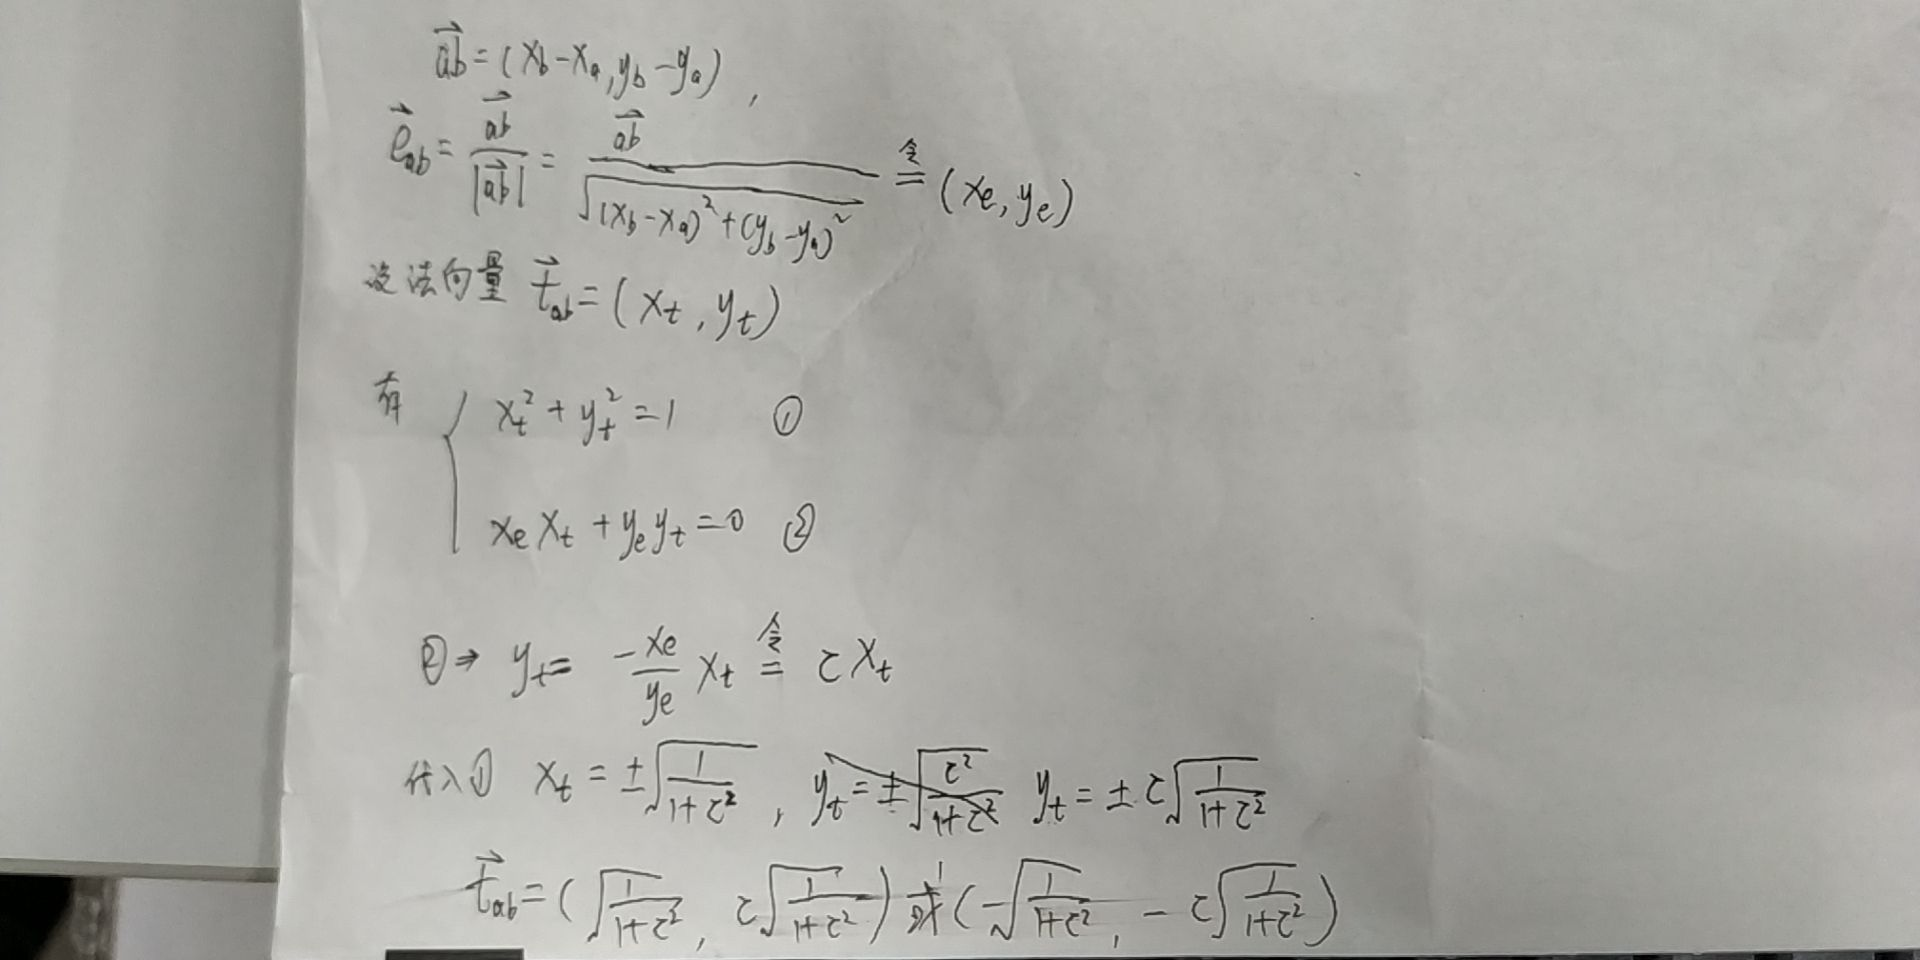



In [31]:
import numpy as np
point_set =[
        [ 0.511278195488722,
          430.0751879699248
        ],        [70.4360902255639,
          395.4887218045113
        ],        [
          147.8796992481203,
          358.64661654135335
        ],        [
          168.18045112781954,
          373.6842105263158
        ],        [
          155.3984962406015,
          400.0
        ],        [
          71.18796992481202,
          438.3458646616541
        ],        [
          0.0,
          465.0
        ]
    ]
p_s = [np.array(p) for p in point_set]
# print(p_s)
direction_vector = [p_s[i+1]-p_s[i] if i<(len(point_set)-1) else p_s[0]-p_s[len(point_set)-1] for i,p in enumerate(p_s)]
print(direction_vector)

[array([ 69.92481203, -34.58646617]), array([ 77.44360902, -36.84210526]), array([20.30075188, 15.03759398]), array([-12.78195489,  26.31578947]), array([-84.21052632,  38.34586466]), array([-71.18796992,  26.65413534]), array([  0.5112782 , -34.92481203])]


In [6]:
#mask方案https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html
import numpy as np
import cv2,json,os,copy
def all_dire_vectors(point_set):#求方向向量
    p_s=[np.array(p) for p in point_set]
    all_direction_vector=[p_s[i+1]-p_s[i] if i<(len(point_set)-1) else p_s[0]-p_s[len(point_set)-1] for i,p in enumerate(p_s)]
#     all_unit_vector=map(unit_vector,all_direction_vector)
#     return map(normal_vector,all_unit_vector)
    return all_direction_vector
def unit_vector(point):#求方向向量的单位向量
    vector_module=np.linalg.norm(point,
                                 ord=2,#二范式（模）
                                 axis=0,#
                                 keepdims=1)
    return point/vector_module
def normal_vector(point):#求法向量
    p=unit_vector(point)
    c_=-p[0]/p[1]#c=-x/y
    t1=np.array([(1/(1+c_**2))**0.5,c_ * (1/(1+c_**2))**0.5])
    t2=-t1
    return t1
def left_normal_vector(point):#求左法向量
    n_v=normal_vector(point)
    if np.cross(point,n_v)<0:
        return n_v
    else:
        return -n_v
def uniform_order(point_set):#统一点集顺序
    increment_point=point_set[0]+left_normal_vector(point_set[0])

#     increment_point=np.round(increment_point)
#     point_set=np.round(point_set)
    increment_point = np.array(increment_point, dtype=np.float32)
    point_set = np.array(point_set, dtype=np.float32)############np.float32    
    #https://blog.csdn.net/weixin_42886817/article/details/102668067
    if cv2.pointPolygonTest(point_set,
                            (increment_point[0],increment_point[1]),0)==1:
        point_set.tolist().reverse()
        return point_set
    else:
        return point_set.tolist()
def increment_point_set(point_set,d_):
    point_set = uniform_order(all_dire_vectors(point_set))
    return [(p+left_normal_vector(p)*d_**0.5).tolist()\
            for p in point_set]

json_path=r'/home/cver/lcx/test/CFM5600010001_LPTN_STAGE 1_Axial cracks_60966.json'
dpath=json_path.split('.')[0]+'test.'+json_path.split('.')[1]
with open(json_path,'r') as f:
    data=json.load(f)
    incremented_set=[]
    for shape in data['shapes']:
        increment_shape=copy.deepcopy(shape)
        increment_shape['points']=increment_point_set(shape['points'],5)
        incremented_set.append(increment_shape)
#     incremented_set=[increment_point_set(shape['points'],10)\
#                      for shape in data['shapes']]
    data['shapes']+=incremented_set
    data['imagePath']=os.path.basename(dpath)
    with open(dpath, 'w') as mf:
        json.dump(data,mf,indent=4)
        print('done')

done


/home/cver/anaconda3/envs/lcx/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars
/home/cver/anaconda3/envs/lcx/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


In [22]:
import numpy as np
x=np.array([[3,4],[6,8]])
y=np.linalg.norm(x,ord=2,axis=0,keepdims=0)
z=-x/y
print("x:{}\ny:{}\nz:{}".format(x,y,z))

x:[[3 4]
 [6 8]]
y:[6.70820393 8.94427191]
z:[[-0.4472136  -0.4472136 ]
 [-0.89442719 -0.89442719]]


In [28]:
import numpy as np
a = np.array([1,2])
b = np.array([7,5])
c = np.cross(a,b)
print(c)

-9


In [29]:
a=[1,2]
def t(a):
    if 1:
        a.reverse()
print(a)
t(a)        
print(a)

[1, 2]
[2, 1]


In [ ]:
json_path=r'/home/cver/lcx/test/CFM5600010001_LPTN_STAGE 1_Axial cracks_60966.json'
with open(json_path,'r') as f:
    data=json.load(f)
    print(data[])

In [4]:
test = [r for (i, c, r) in ((1, 3, True), (2, 4, True), (3, 23, True), (4, 3, True))]
print(test)

[True, True, True, True]
